# Estimating Parameters for the RDPG

In this section, you'll cover a special case of the spectral embedding, which is when you think that the network might be well described by an underlying RDPG. You'll double back on some concepts, such as the singular value decomposition and matrix rank, so that we can explain the importance of these concepts as they relate directly to the probability matrix of an RDPG.

For this example, you'll work with the school example we've seen previously. The nodes are 100 students in total, from one of two schools. Here, the first 50 students are from the first school, and the second 50 students are from the second school. The probability of two students who both go to the first school being friends is $0.5$, and the probability of two students who both go to school two being friends will also be $0.5$. If two students go to different schools, their probability of being friends will be $0.2$. The statistical model has parameters which look like this:

In [22]:
import graspologic as gp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ns1 = 50; ns2 = 50
ns = [ns1, ns2]

# zvec is a column vector of 50 1s followed by 50 2s
# this vector gives the school each of the 100 students are from
zvec = np.array(["S1" for i in range(0, ns1)] + ["S2" for i in range(0, ns2)])

# the block matrix
B = [[0.5, 0.3], [0.3, 0.5]]

# the probability matrix
zvec_ohe = np.vstack([[1, 0] for i in range(0, ns1)] + [[0, 1] for i in range(0, ns2)])
P = zvec_ohe @ B @ zvec_ohe.transpose()

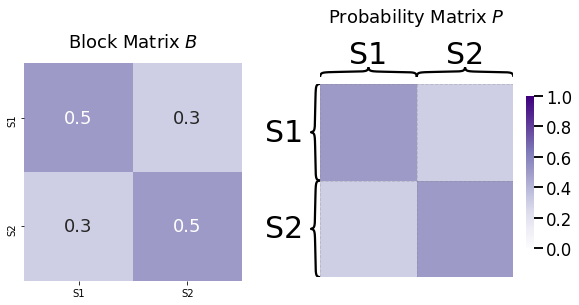

In [23]:
from graphbook_code import cmaps, heatmap

fig, axs = plt.subplots(1,2, figsize=(10,4))

heatmap(np.array(B), ax=axs[0], title="Block Matrix $B$", 
                xticklabels=["S1", "S2"], yticklabels=["S1", "S2"],
                cbar=False, annot=True, vmin=0, vmax=1, cmap=cmaps["sequential"])
heatmap(P, ax=axs[1], inner_hier_labels=zvec,
                title="Probability Matrix $P$", vmin=0, vmax=1, cmap=cmaps["sequential"]);

The procedure for generating the probability matrix from the block probability matrix that you used above is a linear algebra "cheat", but in reality, all that's happening is that you are comparing whether two nodes are in the first or the second school, and then taking the appropriate entry from the block matrix accordingly. The operation is exactly the same as you had in the section on RDPG. For two nodes $i$ and $j$, the probability they are connected is:
\begin{align*}
    p_{ji} = p_{ij}, p_{ij} = \begin{cases}
        b_{11} & z_i = 1, z_j = 1 \\
        b_{12} & z_i = 1, z_j = 2 \\
        b_{22} & z_i = 2, z_j = 2
    \end{cases}
\end{align*}

Next, you will use this probability matrix and the corresponding community assignment vector to generate a sample of the stochastic block model you saw above. This is our "real network":

In [24]:
A = gp.simulations.sbm(ns, B, directed=False, loops=False)

You can see the adjacency matrix and the probability matrix below. Notice that there are two distrinct blocks in the adjacency matrix, which are shared with the probability matrix: in its upper-left, you can see the edges between the first 50 nodes (the individuals in the first school), and in the bottom right, you can see the edges between the second 50 nodes (the individuals in the second school).

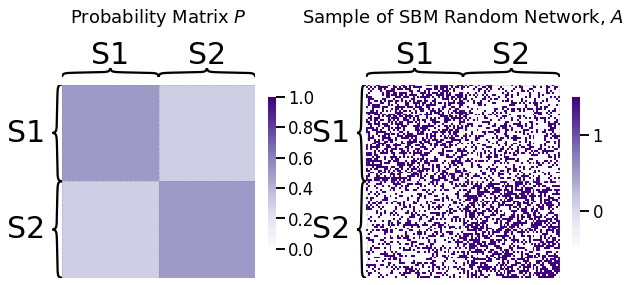

In [27]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

heatmap(P, ax=axs[0], inner_hier_labels=zvec,
                title="Probability Matrix $P$", vmin=0, vmax=1, cmap=cmaps["sequential"]);
heatmap(A.astype(int), ax=axs[1], inner_hier_labels=zvec,
                title="Sample of SBM Random Network, $A$", vmin=0, vmax=1, cmap=cmaps["sequential"]);

As you can see, both the probability matrix $P$ and the sample of the random network $A$ both have a notable "structure", in that it's clear that there are more nodes when both individuals are in the first school (the top left and bottom right "squares" of the adjacency matrix and probability matrix have more entries and are darker, respectively) and fewer nodes when both individuals are in different schools (the top right and bottom left "squares" of the adjacency matrix have fewer entries and are lighter, respectively). 

Next, you have the key conceptual leap you need to take: remember that if a network is an SBM, there is also an underlying RDPG that *also* describes that network. When you learned about this in [Chapter 5](#link?), you learned that this was because the RDPG is a more broad statistical model that was more general than the SBM. So, to learn about the SBM which underlies $A$, you could also learn about an RDPG which underlies $A$, too. This will prove critical in later applications sections, such as [Chapter 8](#link?), when you try to decipher which nodes are in which communities of the network, without having them handed to you in this nice organized way.

## How are nodes from the same community similar?

As it turns out, there's a really important property that is shared by nodes in an SBM random network. Remember that the probability matrix $P$ gives the probabilities $p_{ji}$ of each pair of nodes $i$ and $j$ of being connected. We're going to introduce a new piece of notation here, called the *vector of probabilities* for a single node. The **vector of probabilities** for a node $i$ is the quantity:

\begin{align*}
    \vec p_i &= \begin{bmatrix}
        p_{i1} \\
        \vdots \\
        p_{in}
    \end{bmatrix}
\end{align*}

In words, it is basically just the $i^{th}$ row of the probability matrix $P$. Now, what happens when you look at the probability vectors for nodes which are in the same, versus different communities? Here, what you will do is take the probability vectors for students $1$ and $2$, who both attend school one, and compare them to the probability vectors for students $51$ and $52$, who both attend school two:

In [28]:
# grab the probability vectors for the students you outlined above
Psubset = P[[0, 1, 50, 51],:]

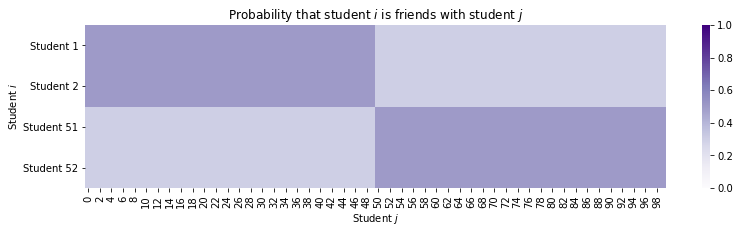

In [39]:
fig, ax = plt.subplots(1,1, figsize=(13, 3))
sns.heatmap(Psubset, ax=ax, vmin=0, vmax=1,
           yticklabels=["Student 1", "Student 2", "Student 51", "Student 52"], cmap=cmaps["sequential"])
ax.set_title("Probability that student $i$ is friends with student $j$")
ax.set_ylabel("Student $i$")
ax.set_xlabel("Student $j$");

The probability vectors for students $1$, $2$, $51$, and $52$ are shown as the rows of the above heatmap. What do you notice about the probability vectors for students $1$ and $2$ in comparison to students $51$ and $52$? As it turns out, they are exactly the same, and the probability vectors are identical! In general, what this means is that, for an SBM, *all* of the nodes in a single community have the *exact same* probability vector! If you are interested in some more details as to why this is the case for an SBM, the reason is that the probability vector for a given node is *fully specified* by just knowing the block matrix and the community assignment vector for the nodes in the network. What this means is that there is nothing special about one node versus another node in the same community, in the probability sense.

## The low-rank property and the probability matrix

Now, what does this mean for *us*? What this means is that the probability matrix has a special property, called the *low-rank* property. We already studied matrix rank, which if you recall, described how many unique row or column vectors you would need to define *all* of the other row and column vectors of a matrix.

If an SBM is has $K$ communities, what does this mean about its probability matrix? Well, its probability matrix is *also* exactly rank-$K$! From what you learned about the Laplacian Spectral Embedding, you might reasonably expect that a very similar procedure might produce a similarly interesting result for us, so let's get started. 

You'll take the svd of the probability matrix of *the random network itself* this time (instead of the Laplacian of a sample of the random network). As you remember, the svd created three matrices, $U$, $\Sigma$, and $V$, for us, with the property that $U$ had $n$ columns called the left singular vectors, $\Sigma$ was a diagonal matrix whose entries were the singular values in non-increasing order (each singular value can be at most the previous), and $V$ also had $n$ columns called the right singular vectors.

Remember that when you take an svd, you start with looking at the scree plot, which was a plot of the singular values ordered by their index:

In [40]:
# take the singular value decomposition
U, s, Vt = np.linalg.svd(P)
# U is the matrix whose columns are the left singular vectors
# s is the vector whose entries are the singular values
# Vt is the matrix whose rows are the right singular vectors
# and whose tranpose has columns which are the right singular vectors

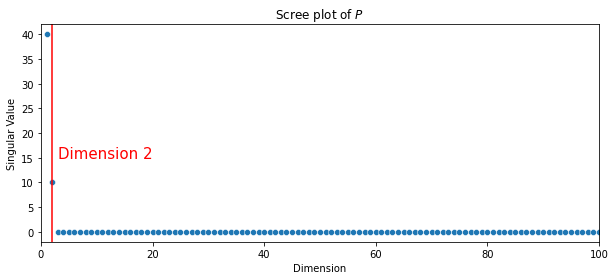

In [41]:
from pandas import DataFrame
def plot_scree(svs, title="", ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(10, 4))
    sv_dat = DataFrame({"Singular Value": svs, "Dimension": range(1, len(svs) + 1)})
    sns.scatterplot(data=sv_dat, x="Dimension", y="Singular Value", ax=ax)
    ax.set_xlim([0, len(s)])
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Singular Value")
    ax.set_title(title)
    ax.axvline(x=2, color='r')
    ax.text(x=3, y=15, s="Dimension 2", color='r', size=15)

plot_scree(s, title="Scree plot of $P$")

What you see in the scree plot is that it just so happens that for the probability matrix for a $K$-community SBM, the probability matrix had $K$ non-zero singular values! This fact will be important to you later on, so you will highlight this later.

Next, you see that $P = U\Sigma V^\top$, and that the expression you learned previously, is still true: that $P = \sum_{i = 1}^n \vec u_i \vec v_i^\top$:

In [42]:
# matrix product form of expression for P
Psvd = U @ np.diag(s) @ Vt

# sum expression for P
# remember that U[:,i] is the ith column of U (the ith left singular vector)
# and Vt[i,:] is the ith column of V (the ith right singular vector)
# and the ith row of Vt (transpose)
Psum = np.sum([s[i]*np.array(U[:,[i]]) @ np.array(Vt[[i],:]) for i in range(0, ns1 + ns2)], 0)

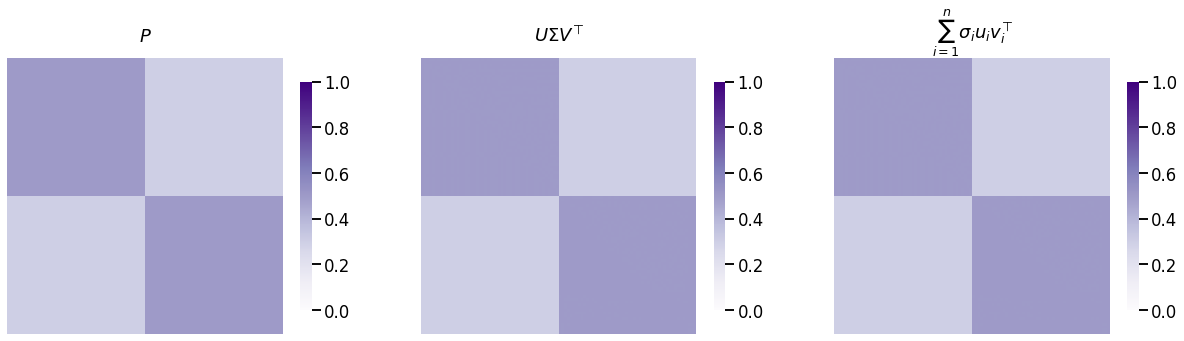

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(21, 6))
 
heatmap(P, ax=axs[0],
                title="$P$", vmin=0, vmax=1, cmap=cmaps["sequential"]);
heatmap(Psvd, ax=axs[1],
                title="$U\\Sigma V^\\top$", vmin=0, vmax=1, cmap=cmaps["sequential"]);
heatmap(Psum, ax=axs[2],
                title="$\\sum_{i = 1}^n \sigma_i u_i v_i^\\top$", vmin=0, vmax=1, cmap=cmaps["sequential"]);

#### The best representation of the probability matrix

As it turns out, the relationships and intuition you learned about the Laplacian Spectral Embedding work here, too. Since the probability matrix $P$ is square, symmetric, and has all positive real entries, it is *also* going to have $K$ positive, real singular values, and the rest will all be zero. Further, the first $K$ left and right singular vectors will all be the same! You'll borrow the same notation you used with the section on the Laplacian Spectral Embedding, remembering that this means that you have two matrices, $U_K$ and $\Sigma_K$, where:
\begin{align*}
    U_K &= \begin{bmatrix}
        \uparrow & & \uparrow \\
        \vec u_1 & ... & \vec u_K \\
        \downarrow & & \downarrow
    \end{bmatrix},\;\;\;\Sigma_K &= \begin{bmatrix}
        \sigma_1 & 0 & ... & 0 \\
        0 & \sigma_2 & \ddots & \vdots \\
        \vdots & \ddots & \ddots & 0 \\
        0 & ... & 0 & \sigma_K
    \end{bmatrix}
\end{align*}
and you learned that $P = U_K\Sigma_K U_K^\top$, or stated another way:
\begin{align*}
    P &= \sum_{i = 1}^K \sigma_i \vec u_i \vec u_i^\top
\end{align*}

We can see this using the probability matrix:

In [44]:
K = 2
UK = U[:,0:K]; SK = np.diag(s[0:K])

# Psymm is UK * SigmaK * UK^transpose
Psymm = UK @ SK @ UK.transpose()
diff = np.linalg.norm(P - Psymm)  # compute the frobenius difference

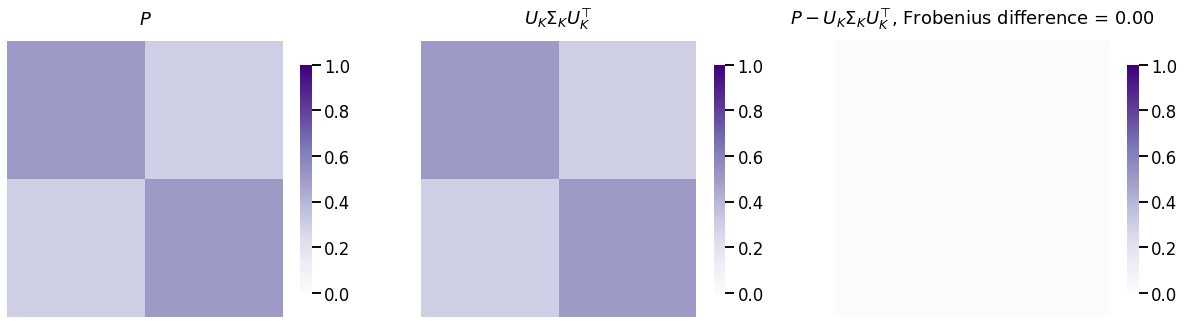

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

heatmap(P, ax=axs[0],
                title="$P$", vmin=0, vmax=1, cmap=cmaps["sequential"]);
heatmap(Psymm, ax=axs[1],
                title="$U_K \\Sigma_K U_K^\\top$", vmin=0, vmax=1, cmap=cmaps["sequential"]);
heatmap(P - Psymm, ax=axs[2],
                title="$P - U_K \\Sigma_K U_K^\\top$, Frobenius difference = {:.2f}".format(diff),
                cmap=cmaps["sequential"], vmin=0, vmax=1);

#### The Square Root Matrix

It's been quite a ride; don't fall off just yet! Now you are really in the home stretch! We've saved the easiest part for last. Remember that $\Sigma_K$ is just a diagonal matrix, whose entries are the singular values $\sigma_i$ for the first $K$ singular values. As it turns out, since $P$ is positive, these singular values are going to be positive too, which means that you can break each singular value into its square root, as $\sigma_i = \sqrt{\sigma_i}\sqrt{\sigma_i}$. 

Like for the Laplacian Spectral Embedding, this meant you could factor the first $K$ singular value matrix $\Sigma_K$ into the product of its square root matrix and its transpose, as $\Sigma_K = \sqrt{\Sigma_K}\sqrt{\Sigma_K}$.

This means that your probability matrix is just $P = U_K \sqrt{\Sigma_K}\sqrt{\Sigma_K}^\top U_K^\top$, which is very similar to what you got for the Laplacian spectral embedding. The difference here is that $P$ *itself* is equal to this quantity, not just a "reduced rank" representation of $P$ like you had for the Laplacian spectral embedding.

If you let $X = U_K \sqrt{\Sigma_K}$, then $P = XX^\top$. This means that $X$ is a latent position matrix for $P$! If you remember back to the [Section on RDPGs](#link?), this means that you have found the latent position parameter for the corresponding RDPG for your SBM random network!

Let's see this using numpy again:

In [47]:
SKsqrt = np.sqrt(SK)
X = UK @ SKsqrt
Prdpg = X @ X.transpose()
diff = np.linalg.norm(P - Prdpg)  # compute the frobenius difference

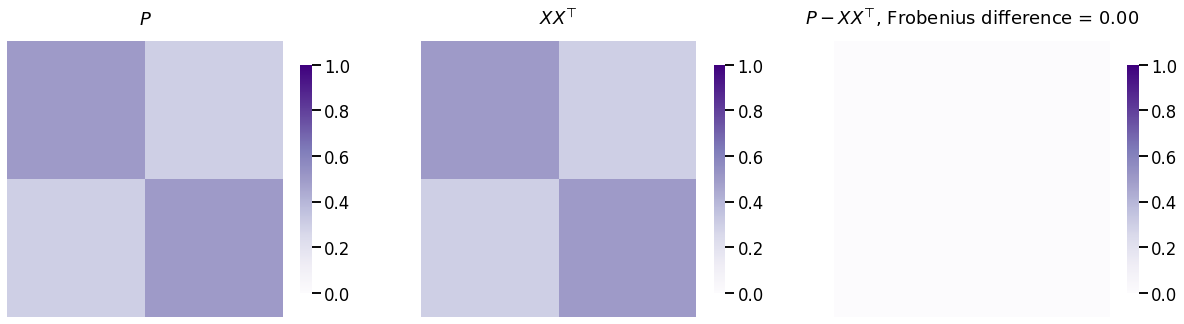

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

heatmap(P, ax=axs[0],
                title="$P$", vmin=0, vmax=1, cmap=cmaps["sequential"]);
heatmap(Prdpg, ax=axs[1],
                title="$XX^\\top$", vmin=0, vmax=1, cmap=cmaps["sequential"]);
heatmap(P - Prdpg, ax=axs[2],
                title="$P - XX^\\top$, Frobenius difference = {:.2f}".format(diff),
                cmap=cmaps["sequential"], vmin=0, vmax=1);

This matrix $X$, the latent position matrix, for an SBM will look like this:

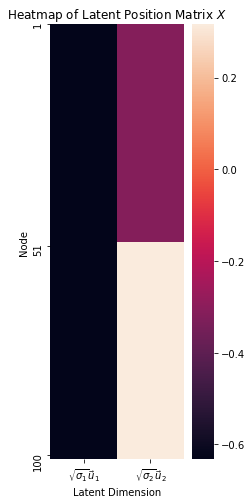

In [49]:
def plot_lpm(D, ax=None, title="", xticks=[], xticklabs=[],
            yticks=[], yticklabs=[], cbar=True):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3,8))
    sns.heatmap(D, ax=ax, cbar=cbar)
    ax.set_xlabel("Latent Dimension")
    ax.set_ylabel("Node")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabs)
    ax.set_title(title);

plot_lpm(X, xticks=[0.5, 1.5], xticklabs=["$\\sqrt{\\sigma_1}\\vec u_1$", "$\\sqrt{\\sigma_2}\\vec u_2$"],
        yticks=[0, 51, 99], title="Heatmap of Latent Position Matrix $X$",
        yticklabs=["1", "51", "100"])

and is the "low-rank structure" which describes the probability matrix. 

### The latent positions are distinct for each community

Now, you will notice a very interesting property about the latent position matrix for an SBM. Remember that for an RDPG (and an SBM is also an RDPG), the latent position vectors for the node $i$ are the *rows* $\vec x_i$ of the latent position matrix $X$. This means that the latent position vector for node $1$ is the vector $(\sqrt{\sigma_1}u_{11}, \sqrt{\sigma_2}u_{21})$. What do you notice about the latent positions vector for node $2$? It's *exactly* the same! 

More generally, the latent position vector for *all* nodes which are in the same community will be identical. This is why if you look across the latent position matrix $X$ above, there are only two unique latent position vectors: there are one unique vector (which is black in the first dimension and red in the second dimension) for the nodes in the first community, and a second unique vector (which is black in the first dimension and beige in the second dimension) for the nodes of the second community.

```{admonition} Putting it all together
What have you learned so far? What we've learned so far is that, if you have a probability matrix that is symmetric and rank-$K$:
1. We can decompose this probability matrix using the singular value decomposition.
2. We can ignore singular values/vectors other than the first $K$ of them.
3. For the first $K$ singular vectors, the left and right vectors are identical.
4. We can decompose the singular value matrix into the product of the square root matrix with its transpose.
5. We can express the matrix $P$ using the latent position matrix $X$, which is the product of the first $K$ singular vectors with the first $K$ singular values.
This means that you have found a latent position matrix $X$ for the probability matrix using the singular values and singular vectors of $P$, by effectively just discarding the ones that don't matter (and have singular values of $0$). We have succeeded in our goal of finding a much lower rank structure, the latent position matrix $X$, to describe the probability matrix $P$.
```

If you remember from the section on RDPGs, this probability matrix has the property that each entry $p_{ij} = \vec x_i \vec x_j^\top$.

## But wait: you don't have the probability matrix! What do you do?

All of the logic you developed above was with respect to the probability matrix, $P$, for a SBM. More generally, this logic extends to the probability matrix $P$ for any RDPG, which is because an RDPG with $d$ latent dimensions will *always* have a probability matrix that is *exactly* rank $d$. If you took the latent position matrix $X$ which had $d$ latent dimensions, and then used the svd to find the $U_d$ and $\Sigma_d$ where $P = U_d \Sigma_d U_d^\top$, you could find another latent position matrix $Y = U_d\sqrt{\Sigma_d}$ where $P = YY^\top$.

But, you have a slight issue: when you perform machine learning, you don't know the probability matrix! The probability matrix is a *parameter* of the statistical model itself, it is *not* a function of the sample of data you get. All you have is the adjacency matrix itself, $A$, which is your data! We don't actually know what the underlying probability matrix is! How the heck can you find this low rank structure you want to be able to estimate?

As it turns out, if you kept obtaining more and more networks $A$ from the underlying RDPG random network $\mathbf A$, you would *expect* that the network $A$ you saw would be the probability matrix $P$. We'll explain what you mean by expect here by turning back to your coin flip example. As you remember, you perform a coin flip at each pair of nodes $i$ and $j$ of an RDPG, where the coin lands on heads with probability $\vec x_i\vec x_j^\top$, and lands on tails with probability $1 - \vec x_i\vec x_j^\top$. This means you can *expect* the coin to land on heads with probability $\vec x_i\vec x_j^\top$. In the same sense, you can expect the $(i,j)$ entry of the adjacency matrix $A$ to exist with probability $\vec x_i \vec x_j^\top$. In this sense, the expected value of the adjacency matrix $A$ *is* the probability matrix $P = XX^\top$. 

So, since the expected value of the adjacency matrix *is* the probability matrix, what if you were to just embed the adjacency matrix instead? Let's see how this might work. Again, you'll use the singular value decomposition on $A$, and take a look at the scree plot for $A$, and compare it to the scree plot of $P$:

In [50]:
UA, sA, VAt = np.linalg.svd(A)

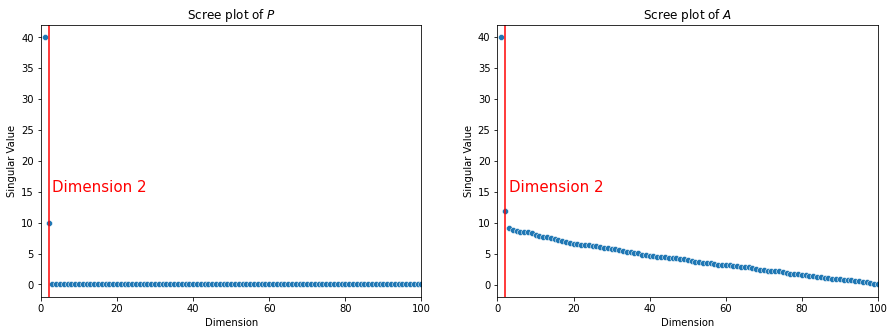

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plot_scree(s, title="Scree plot of $P$", ax=axs[0])
plot_scree(sA, title="Scree plot of $A$", ax=axs[1])

Now that's really funky! The singular values of both $P$ and $A$ tend to fall off around *roughly* the same spot, right around dimension $2$! The singular value of $P$ go directly to $0$, but the singular values for $A$ tend to "round off" in the direction of $0$, but it isn't *too* far off!

As it turns out, this is no coincidence: the singular values for a network which can be described by an RDPG will tend to "elbow" off right around the number of true latent dimensions for the probability matrix of the underlying random network. If the RDPG has $d$ latent dimensions, this will occur right around $d$. For this reason, it is usually a good idea when you think a network might be well described by an RDPG to let the elbow selection algorithm do the work for us, and then take a good look at the scree plot to make sure the number of latent dimensions chosen seems reasonable to us. If you don't know how many latent dimensions to retain, you'll call the number of embedding dimensions $\hat d$, which just means, "estimate of the number of latent dimensions".

What does it look like when you use the spectral embedding on $A$? You'll compare the embedding of the adjacency matrix to the latent positions of the probability matrix:

In [52]:
UAK = UA[:,0:K]; USK = np.diag(np.sqrt(sA[0:K]))
Aembedded = UAK @ USK

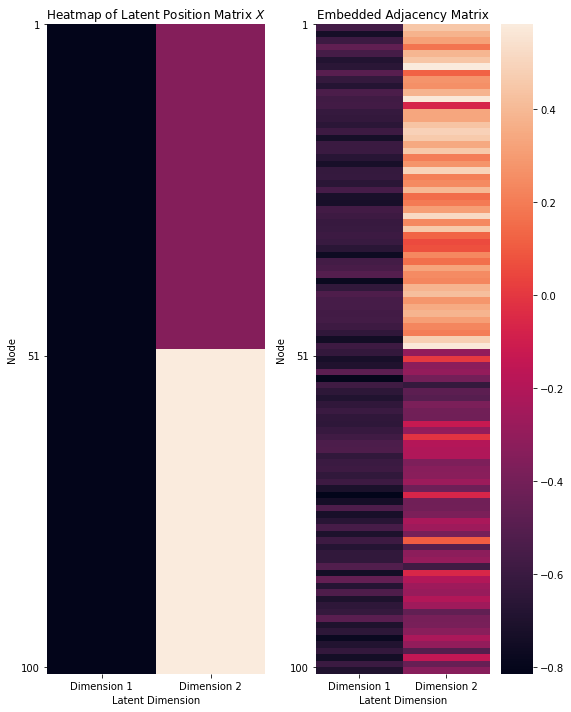

In [53]:
fig, axs = plt.subplots(1,2, figsize=(8, 10))

plot_lpm(X, xticks=[0.5, 1.5], xticklabs=["Dimension 1", "Dimension 2"],
        yticks=[0, 51, 99], title="Heatmap of Latent Position Matrix $X$",
        yticklabs=["1", "51", "100"], ax=axs[0], cbar=False)

plot_lpm(Aembedded, xticks=[0.5, 1.5], xticklabs=["Dimension 1", "Dimension 2"],
        yticks=[0, 51, 99], title="Embedded Adjacency Matrix",
        yticklabs=["1", "51", "100"], ax=axs[1])
fig.tight_layout()

Wow! When you take the adjacency matrix and embed it into $2$ dimensions, it doesn't look *identical* to the latent position matrix, but it shares some major patterns with it! In particular, it looks like the second latent dimension for the embedded adjacency matrix tends to capture that the second latent dimension of $X$ has higher values for the first $50$ nodes, and lower values for the second $50$ nodes. For a variety of reasons, you will call this "embedding of $A$" an *estimate* of the latent position matrix for the underlying RDPG, which you will denote by $\hat X$. 

As you learned in the last section, this entire procedure is automated for you by `graspologic` with the `AdjacencySpectralEmbed()` class, or alternatively, the `RDPGEstimator()`. The `RDPGEstimator()` class just makes clear that you are estimating parameters for an RDPG:

In [54]:
rdpgest = gp.models.RDPGEstimator()
rdpgest = rdpgest.fit(A)
Xhat = rdpgest.latent_

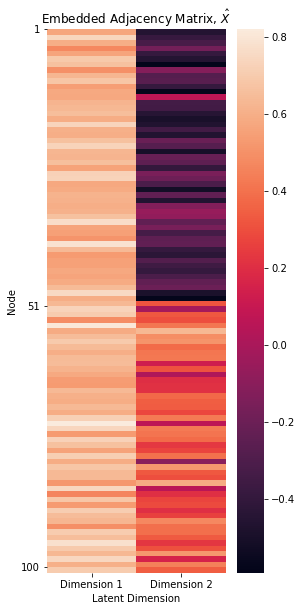

In [55]:
fig, ax = plt.subplots(1,1, figsize=(4, 10))

plot_lpm(Xhat, xticks=[0.5, 1.5], xticklabs=["Dimension 1", "Dimension 2"],
        yticks=[0, 51, 99], title="Embedded Adjacency Matrix, $\hat X$",
        yticklabs=["1", "51", "100"], ax=ax)

As it turns out, this example here is a good instance of another property of the latent position matrix. Remember that the latent position matrix is the matrix $X$ where $P = XX^\top$. As it turns out, sometimes the columns of this matrix can get flipped around a little bit, through something called a rotation. You can see this by noticing that it looks a lot like the entries of the estimates of the latent position matrix are positive in one case are negative for the other, and it basically looks like the colorbar just got flipped around on us. The rotation doesn't really matter (yet!), and $P$ still is equal to $XX^\top$, regardless of how that $X$ is rotated. You'll learn more about rotation matrices in the upcoming section on [Multiple Network Representation Learning](#link?) and in the section on [Two Sample Hypothesis Testing](#link?), but for now, all you need to know is that this "flippage" of what's big and small in the latent position matrix is not too important (again, yet!).

## When should you use ASE and when should you use LSE?

In the last two sections, you learned about ASE and LSE, and discussed how each can be used to reasonably embed network data. So, what's the difference? When should you use one approach versus the other?

Well, it turns out that LSE and ASE capture different notions of "structure" when embedding a network. Carey Priebe and collaborators at Johns Hopkins University investigated this recently, in 2018, and discovered that LSE tends to capture "affinity" structure, whereas ASE tends to capture "core-periphery" structure (their paper is called "On a two-truths phenomenon in spectral graph clustering" - it's an interesting read for the curious). What do these words mean?

In a sentence, affinity structure is a property under which there exist communities of nodes in the network, and those nodes tend to be more heavily connected within-community than between-community (nodes in the same community have more *affinity* for one another, also known as *homophily*). Think of a friend network in two schools, where people within the same school are much more likely to be friends than people in different schools. This is a type of structure we've seen a lot in this book in your Stochastic Block Model examples.

On the other hand, a core-periphery structure is a property under which there exists a subset of nodes in the network which have much higher degrees than other nodes in the network (the *core* of the network, since most of the edges are found in the *core* nodes), and there are other subsets of nodes which tend to have much lower degrees than other nodes in the network (the *periphery* of the network, since these nodes tend to take a secondary position edge wise to the *core* nodes). Think of a core of popular, well-liked, and charismatic kids at a high school, with a periphery of loners or people who prefer not to socialize as much.

First, you going to generate an affinity structure in an SBM with $2$ communities, and plot both the probability matrix and a sample of an example of this type of network. The network will have $100$ nodes, and $50$ nodes in each community:

In [56]:
n1 = 50; n2 = 50
Baff = [[0.5, 0.2], [0.2, 0.5]]

zvecaff = np.array(["C1" for i in range(0, n1)] + ["C2" for i in range(0, n2)])

# the probability matrix
zvecaff_ohe = np.vstack([[1, 0] for i in range(0, n1)] + [[0, 1] for i in range(0, n2)])
Paff = zvecaff_ohe @ Baff @ zvecaff_ohe.T

Aaff = gp.simulations.sbm([n1, n2], Baff, directed=False, loops=False)

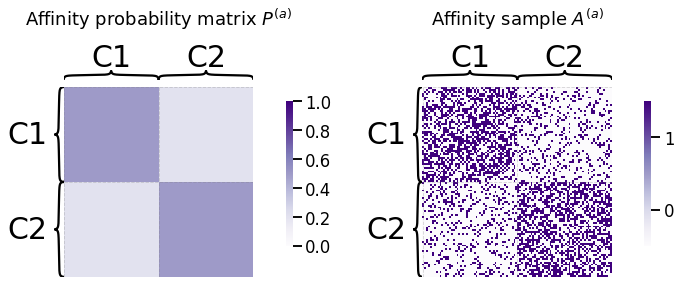

In [59]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

heatmap(Paff, ax=axs[0], inner_hier_labels=zvecaff,
                title="Affinity probability matrix $P^{(a)}$", vmin=0, vmax=1, cmap=cmaps["sequential"]);
heatmap(Aaff.astype(int), ax=axs[1], inner_hier_labels=zvecaff,
                title="Affinity sample $A^{(a)}$", vmin=0, vmax=1, cmap=cmaps["sequential"]);
fig.tight_layout()

As you can see, the nodes in communities one and two tend to be more highly connected within community (homophilic affinity) than between. 

Next, you generate another network with core-periphery structure in an SBM with 3 communities, where the first $15$ nodes are the first peripheral group, the second $70$ nodes are the "core", and the last $15$ nodes are the second periphery group:

In [60]:
np1 = 15; nc = 70; np2 = 15
Bcp = [[0.1, 0.1, 0.1],
      [0.1, 0.7, 0.1],
      [0.1, 0.1, 0.1]]


zveccp = np.array(["Per." for i in range(0, np1)] +
                  ["Core" for i in range(0, nc)] +
                  ["Per." for i in range(0, np2)])

# the probability matrix
zveccp_ohe = np.vstack([[1, 0, 0] for i in range(0, np1)] + 
                       [[0, 1, 0] for i in range(0, nc)] +
                       [[0, 0, 1] for i in range(0, np2)])
Pcp = zveccp_ohe @ Bcp @ zveccp_ohe.T

Acp = gp.simulations.sbm([np1, nc, np2], Bcp, directed=False, loops=False)

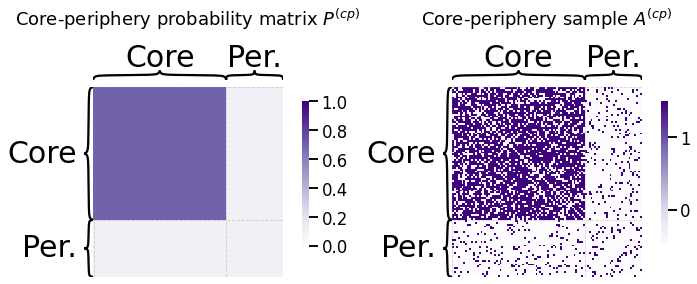

In [62]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

heatmap(Pcp, ax=axs[0], inner_hier_labels=zveccp, sort_nodes=False,
                title="Core-periphery probability matrix $P^{(cp)}$", vmin=0, vmax=1, cmap=cmaps["sequential"]);
heatmap(Acp.astype(int), ax=axs[1], inner_hier_labels=zveccp, sort_nodes=False,
                title="Core-periphery sample $A^{(cp)}$", vmin=0, vmax=1, cmap=cmaps["sequential"]);
fig.tight_layout()

What if the network has *both* core-periphery *and* affinity structure? Let's consider a slight augmentation of the above networks, where within the probability of a given node $i$ being connected to another node $j$ is an *average* of its core-periphery and affinity probabilities:

In [63]:
Pcp_and_aff = (Paff + Pcp)/2
Acp_and_aff = gp.simulations.sample_edges(Pcp_and_aff, directed=False, loops=False)

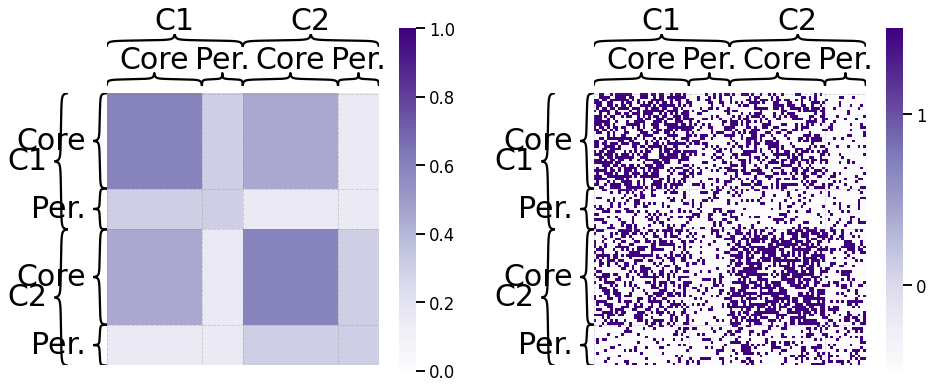

In [65]:
fig, axs = plt.subplots(1,2, figsize=(16,9))

heatmap(Pcp_and_aff, ax=axs[0], inner_hier_labels=zveccp, outer_hier_labels=zvecaff,
                title="", vmin=0, vmax=1, cmap=cmaps["sequential"]);
heatmap(Acp_and_aff.astype(int), ax=axs[1], inner_hier_labels=zveccp, outer_hier_labels=zvecaff,
                title="", vmin=0, vmax=1, cmap=cmaps["sequential"]);

When you embed the networks using ASE, you tend to obtain estimated latent positions where nodes in the same community tend to have similar estimates:

In [66]:
from graspologic.embed import AdjacencySpectralEmbed as ASE
ase = ASE(n_components=2)
Xhat_ase = ase.fit_transform(Acp_and_aff)

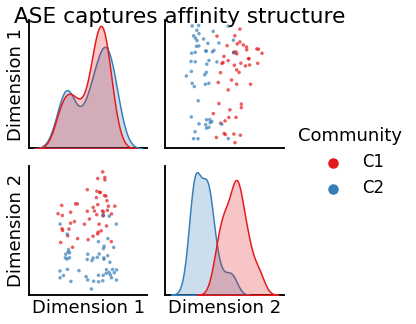

In [67]:
from graspologic.plot import pairplot
_ = pairplot(Xhat_ase, labels=zvecaff, legend_name="Community", 
             title="ASE captures affinity structure");

And when you embed the networks using LSE, you tend to obtain estimated latent positions where nodes which are in the core are distinct from the nodes in the periphery:

In [68]:
from graspologic.embed import LaplacianSpectralEmbed as LSE
lse = LSE(n_components=2)
Xhat_lse = lse.fit_transform(Acp_and_aff)

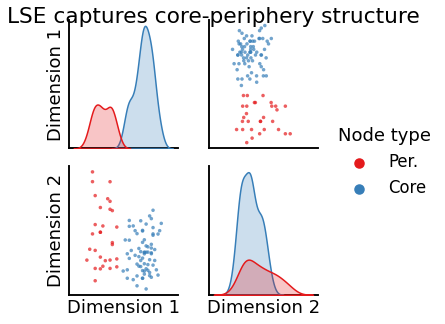

In [69]:
from graspologic.plot import pairplot
_ = pairplot(Xhat_lse, labels=zveccp, legend_name="Node type", 
             title="LSE captures core-periphery structure");

ASE and LSE each captured a different, but still *true*, truth about the underlying network.